In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point 
from geopandas.tools import sjoin
import pysal as ps
from IPython.display import display

In [2]:
# from IPython.display import IFrame
# IFrame()

In [2]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
#cs_dir = 'D:/Data/CanadaFood/data/2016_GeoData_CanadaStatistics/'
cs_dir = '/home/sausy/NB/2016CFS_analysis_190318_Liu_AS/spatialfiles_CFS16/'
cs_dir2 = '/home/sausy/NB/2016CFS_analysis_190318_Liu_AS/aspatialfiles_CFS16/'

### 1. map Provinces, 5 metropolitan areas, and activity locations

In [4]:
prov = gpd.read_file(cs_dir + '2016_Provinces/lpr_000b16a_e.shp')
metropo_all = gpd.read_file(cs_dir + '2016_Census metropolitan areas/lcma000b16a_e.shp')
da = gpd.read_file(cs_dir + '2016_DisseminationAreas/lda_000b16a_e.shp')

In [5]:
metropo5 = metropo_all[(metropo_all.CMANAME == 'Halifax') | (metropo_all.CMANAME == 'Montréal') | \
       (metropo_all.CMANAME == 'Toronto') | (metropo_all.CMANAME == 'Edmonton') | \
       (metropo_all.CMANAME == 'Vancouver')]
metropo5.CMANAME.replace('Montréal','Montreal', inplace = True) #prepare for linkage later
metropo5

/usr/lib/python3/dist-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,geometry
7,462,24462,Montreal,B,24,Quebec / Québec,"(POLYGON ((7635857.25143 1298408.934285, 76365..."
24,205,12205,Halifax,B,12,Nova Scotia / Nouvelle-Écosse,"(POLYGON ((8467527.014285 1530676.737145, 8467..."
89,535,35535,Toronto,B,35,Ontario,"(POLYGON ((7217656.32 1019923.02857, 7217651.0..."
129,933,59933,Vancouver,B,59,British Columbia / Colombie-Britannique,"(POLYGON ((4042996.157145 2027876.065715, 4045..."
149,835,48835,Edmonton,B,48,Alberta,"POLYGON ((4819297.31143 2218897.894285, 482077..."


In [6]:
da5 = da[(da.CMANAME=='Toronto')|(da.CMANAME=='Halifax')|(da.CMANAME=='Montréal')|(da.CMANAME=='Edmonton')|(da.CMANAME=='Vancouver')]
da5.head()

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,CSDTYPE,ERUID,ERNAME,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,CTUID,CTNAME,ADAUID,geometry
988,12090733,12,Nova Scotia / Nouvelle-Écosse,1209,Halifax,CTY,1209034,Halifax,1209034,Halifax,RGM,1250,Halifax,205,1,205,12205,Halifax,B,2050121.05,0121.05,12090030,"POLYGON ((8420792.991429999 1442444.805715, 84..."
1297,12090267,12,Nova Scotia / Nouvelle-Écosse,1209,Halifax,CTY,1209034,Halifax,1209034,Halifax,RGM,1250,Halifax,205,1,205,12205,Halifax,B,2050001.00,0001.00,12090051,"POLYGON ((8411796.442855 1435497.925715, 84118..."
1298,12090270,12,Nova Scotia / Nouvelle-Écosse,1209,Halifax,CTY,1209034,Halifax,1209034,Halifax,RGM,1250,Halifax,205,1,205,12205,Halifax,B,2050001.00,0001.00,12090051,"POLYGON ((8412191.611430001 1435034.622855, 84..."
1299,12090271,12,Nova Scotia / Nouvelle-Écosse,1209,Halifax,CTY,1209034,Halifax,1209034,Halifax,RGM,1250,Halifax,205,1,205,12205,Halifax,B,2050001.00,0001.00,12090051,"POLYGON ((8412214.585715 1435035.52, 8412245.9..."
1393,12090521,12,Nova Scotia / Nouvelle-Écosse,1209,Halifax,CTY,1209034,Halifax,1209034,Halifax,RGM,1250,Halifax,205,1,205,12205,Halifax,B,2050026.02,0026.02,12090057,"POLYGON ((8405601.425714999 1441711.982855, 84..."


load activity locations

In [7]:
actloc_16 = pd.read_csv('./outputs_CFS16/locations.csv',\
                         header=0, index_col=None)
print(actloc_16.shape)
actloc_16.head()

(8708, 7)


,user_id,location_id,lon,lat,description,used,duration
0,16995FBB-9168-470C-8EC9-0F70EE104EAB,1,-73.606574,45.521986,NaN,True,2730.658542
1,16995FBB-9168-470C-8EC9-0F70EE104EAB,2,-73.587285,45.519229,NaN,True,1378.170750
2,16995FBB-9168-470C-8EC9-0F70EE104EAB,3,-73.589774,45.522109,NaN,True,144771.005588
3,16995FBB-9168-470C-8EC9-0F70EE104EAB,4,-73.589090,45.573478,NaN,True,13510.274296
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,NaN,False,0.000000


create geopandas object from pandas<br>https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html<br>
setting a coordinates reference system (in this case: lon/lat is WGS84)<br>http://geopandas.org/projections.html

reproject to the crs used in CanadaStatisticsBoundries (like prov, also align with metropo5, da5)

In [23]:
actloc_16['Coordinates'] = list(zip(actloc_16.lon, actloc_16.lat))
actloc_16['Coordinates'] = actloc_16['Coordinates'].apply(Point)
actloc_16 = gpd.GeoDataFrame(actloc_16, crs={'init':'epsg:4326'}, geometry='Coordinates').to_crs(prov.crs)
actloc_16.head()

,user_id,location_id,lon,lat,description,used,duration,Coordinates
0,16995FBB-9168-470C-8EC9-0F70EE104EAB,1,-73.606574,45.521986,NaN,True,2730.658542,POINT (7628124.775411434 1245936.147426194)
1,16995FBB-9168-470C-8EC9-0F70EE104EAB,2,-73.587285,45.519229,NaN,True,1378.170750,POINT (7629679.758065347 1246071.257450704)
2,16995FBB-9168-470C-8EC9-0F70EE104EAB,3,-73.589774,45.522109,NaN,True,144771.005588,POINT (7629398.403365474 1246326.868796679)
3,16995FBB-9168-470C-8EC9-0F70EE104EAB,4,-73.589090,45.573478,NaN,True,13510.274296,POINT (7627808.349992666 1251898.589754359)
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,NaN,False,0.000000,POINT (7212892.722293774 940406.3008696423)


add the column `S1A_city` in `actloc_17`

In [24]:
ana_link = pd.read_csv(cs_dir2 + '2016CFS_S1A_combineUserLinkAnaDaysDura_20181129_Liu.csv', sep=',', header=0, index_col=None)
ana_link.columns

Index(['uuid', 'S1A_Vrid', 'id', 'email', 'email_lowercase', 'model',
       'created_at', 'use_notifications', 'version', 'os',
       ...
       'S1A_hhld_size_n_DV', 'S1A_income', 'S1A_income_DV', 'S1A_income_adeq',
       'S1A_prov', 'S1A_BMI_DV', 'S1A_BMI_class_DV', 'total_min', 'total_day',
       'sum_actdura'],
      dtype='object', length=1194)


In [25]:
ana_link.S1A_city.unique()

array([3, 1, 5, 2, 4])

In [29]:
ana_link.S1A_city.replace([1,2,3,4,5], ['Toronto','Montreal','Halifax','Edmonton','Vancouver'],inplace = True)
ana_link.head()

,uuid,S1A_Vrid,id,email,email_lowercase,model,created_at,use_notifications,version,os,osversion,user_email_InvS1_EmailLowercase673,InvS1_EmailLowercase,user_email_InvS1_S1A_email670,S1A_email,user_email_InvS1_S1B_email_lowercase663,S1B_email_lowercase,user_email_S2A_email668,S2A_email,user_email_S2B_email675,S2B_email,user_email_S2B_email_lowercase675,S2B_email_lowercase,S1A_resp_counter,S1A_weight_DV,S1A_Vdatesub,S1A_monthsub_DV,S1A_Vstatus,S1A_mobileuser_DV,S1A_Vlanguage,S1A_city,S1A_age,S1A_age_DV,S1A_consent,S1A_gender,S1A_gender_otext,S1A_sex,S1A_student,S1A_educ_curr,S1A_educ_curr_otext,S1A_educ_curr_DV,S1A_work,S1A_occup_DV,S1A_child_any,S1A_child_n,S1A_child_home,S1A_child1_age_DV,S1A_child2_age_DV,S1A_child3_age_DV,S1A_child4_age_DV,S1A_child5_age_DV,S1A_child6_age_DV,S1A_child7_age_DV,S1A_child8_age_DV,S1A_child_resp,S1A_live_parent,S1A_live_room,S1A_live_spouse,S1A_live_child,S1A_live_school,S1A_live_alone,S1A_live_other,S1A_live_DK,S1A_live_R,S1A_live_otext,S1A_TodayMinus1,S1A_TodayMinus2,S1A_TodayMinus3,S1A_TodayMinus4,S1A_TodayMinus5,S1A_TodayMinus6,S1A_TodayMinus7,S1A_Day1_Breakfast,S1A_Day1_Lunch,S1A_Day1_Dinner,S1A_Day1_Other,S1A_Day1_B1,S1A_Day1_B2,S1A_Day1_B3,S1A_Day1_B4,S1A_Day1_B5,S1A_Day1_B6,S1A_Day1_B7,S1A_Day1_B8,S1A_Day1_B9,S1A_Day1_BDK,S1A_Day1_BR,S1A_Day1_B9O,S1A_Day1_L1,S1A_Day1_L2,S1A_Day1_L3,S1A_Day1_L4,S1A_Day1_L5,S1A_Day1_L6,S1A_Day1_L7,S1A_Day1_L8,S1A_Day1_L9,S1A_Day1_LDK,S1A_Day1_LR,S1A_Day1_L9O,S1A_Day1_D1,S1A_Day1_D2,S1A_Day1_D3,S1A_Day1_D4,S1A_Day1_D5,S1A_Day1_D6,S1A_Day1_D7,S1A_Day1_D8,S1A_Day1_D9,S1A_Day1_DDK,S1A_Day1_DR,S1A_Day1_D9O,S1A_Day1_O1,S1A_Day1_O2,S1A_Day1_O3,S1A_Day1_O4,S1A_Day1_O5,S1A_Day1_O6,S1A_Day1_O7,S1A_Day1_O8,S1A_Day1_O9,S1A_Day1_ODK,S1A_Day1_OR,S1A_Day1_O9O,S1A_Day2_Breakfast,S1A_Day2_Lunch,S1A_Day2_Dinner,S1A_Day2_Other,S1A_Day2_B1,S1A_Day2_B2,S1A_Day2_B3,S1A_Day2_B4,S1A_Day2_B5,S1A_Day2_B6,S1A_Day2_B7,S1A_Day2_B8,S1A_Day2_B9,S1A_Day2_BDK,S1A_Day2_BR,S1A_Day2_B9O,S1A_Day2_L1,S1A_Day2_L2,S1A_Day2_L3,S1A_Day2_L4,S1A_Day2_L5,S1A_Day2_L6,S1A_Day2_L7,S1A_Day2_L8,S1A_Day2_L9,S1A_Day2_LDK,S1A_Day2_LR,S1A_Day2_L9O,S1A_Day2_D1,S1A_Day2_D2,S1A_Day2_D3,S1A_Day2_D4,S1A_Day2_D5,S1A_Day2_D6,S1A_Day2_D7,S1A_Day2_D8,S1A_Day2_D9,S1A_Day2_DDK,S1A_Day2_DR,S1A_Day2_D9O,S1A_Day2_O1,S1A_Day2_O2,S1A_Day2_O3,S1A_Day2_O4,S1A_Day2_O5,S1A_Day2_O6,S1A_Day2_O7,S1A_Day2_O8,S1A_Day2_O9,S1A_Day2_ODK,S1A_Day2_OR,S1A_Day2_O9O,S1A_Day3_Breakfast,S1A_Day3_Lunch,S1A_Day3_Dinner,S1A_Day3_Other,S1A_Day3_B1,S1A_Day3_B2,S1A_Day3_B3,S1A_Day3_B4,S1A_Day3_B5,S1A_Day3_B6,S1A_Day3_B7,S1A_Day3_B8,S1A_Day3_B9,S1A_Day3_BDK,S1A_Day3_BR,S1A_Day3_B9O,S1A_Day3_L1,S1A_Day3_L2,S1A_Day3_L3,S1A_Day3_L4,S1A_Day3_L5,S1A_Day3_L6,S1A_Day3_L7,S1A_Day3_L8,S1A_Day3_L9,S1A_Day3_LDK,S1A_Day3_LR,S1A_Day3_L9O,S1A_Day3_D1,S1A_Day3_D2,S1A_Day3_D3,S1A_Day3_D4,S1A_Day3_D5,S1A_Day3_D6,S1A_Day3_D7,S1A_Day3_D8,S1A_Day3_D9,S1A_Day3_DDK,S1A_Day3_DR,S1A_Day3_D9O,S1A_Day3_O1,S1A_Day3_O2,S1A_Day3_O3,S1A_Day3_O4,S1A_Day3_O5,S1A_Day3_O6,S1A_Day3_O7,S1A_Day3_O8,S1A_Day3_O9,S1A_Day3_ODK,S1A_Day3_OR,S1A_Day3_O9O,S1A_Day4_Breakfast,S1A_Day4_Lunch,S1A_Day4_Dinner,S1A_Day4_Other,S1A_Day4_B1,S1A_Day4_B2,S1A_Day4_B3,S1A_Day4_B4,S1A_Day4_B5,S1A_Day4_B6,S1A_Day4_B7,S1A_Day4_B8,S1A_Day4_B9,S1A_Day4_BDK,S1A_Day4_BR,S1A_Day4_B9O,S1A_Day4_L1,S1A_Day4_L2,S1A_Day4_L3,S1A_Day4_L4,S1A_Day4_L5,S1A_Day4_L6,S1A_Day4_L7,S1A_Day4_L8,S1A_Day4_L9,S1A_Day4_LDK,S1A_Day4_LR,S1A_Day4_L9O,S1A_Day4_D1,S1A_Day4_D2,S1A_Day4_D3,S1A_Day4_D4,S1A_Day4_D5,S1A_Day4_D6,S1A_Day4_D7,S1A_Day4_D8,S1A_Day4_D9,S1A_Day4_DDK,S1A_Day4_DR,S1A_Day4_D9O,S1A_Day4_O1,S1A_Day4_O2,S1A_Day4_O3,S1A_Day4_O4,S1A_Day4_O5,S1A_Day4_O6,S1A_Day4_O7,S1A_Day4_O8,S1A_Day4_O9,S1A_Day4_ODK,S1A_Day4_OR,S1A_Day4_O9O,S1A_Day5_Breakfast,S1A_Day5_Lunch,S1A_Day5_Dinner,S1A_Day5_Other,S1A_Day5_B1,S1A_Day5_B2,S1A_Day5_B3,S1A_Day5_B4,S1A_Day5_B5,S1A_Day5_B6,S1A_Day5_B7,S1A_Day5_B8,S1A_Day5_B9,S1A_Day5_BDK,S1A_Day5_BR,S1A_Day5_B9O,S1A_Day5_L1,S1A_Day5_L2,S1A_Day5_L3,S1A_Day5_L4,S1A_Day5_L5,S1A_Day5_L6,S1A_Day5_L7,S1A_Day5_L8,S

In [31]:
actloc_16 = actloc_16.join(ana_link.set_index('uuid')[['S1A_city']], on = 'user_id', how = 'left')
actloc_16

,user_id,location_id,lon,lat,description,used,duration,Coordinates,S1A_city
0,16995FBB-9168-470C-8EC9-0F70EE104EAB,1,-73.606574,45.521986,NaN,True,2730.658542,POINT (7628124.775411434 1245936.147426194),Montreal
1,16995FBB-9168-470C-8EC9-0F70EE104EAB,2,-73.587285,45.519229,NaN,True,1378.170750,POINT (7629679.758065347 1246071.257450704),Montreal
2,16995FBB-9168-470C-8EC9-0F70EE104EAB,3,-73.589774,45.522109,NaN,True,144771.005588,POINT (7629398.403365474 1246326.868796679),Montreal
3,16995FBB-9168-470C-8EC9-0F70EE104EAB,4,-73.589090,45.573478,NaN,True,13510.274296,POINT (7627808.349992666 1251898.589754359),Montreal
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,NaN,False,0.000000,POINT (7212892.722293774 940406.3008696423),Toronto
5,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,NaN,True,14828.164194,POINT (7212352.01805819 939935.3238804098),Toronto
6,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,NaN,False,0.000000,POINT (7227856.233284539 931031.3338662987),Toronto
7,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,NaN,True,4225.763820,POINT (7227992.377457372 931172.1832322327),Toronto
8,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,NaN,True,570302.842476,POINT (7228137.124546573 931285.4521353885),Toronto
9,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,1,-73.575378,45.508685,NaN,True,15130.723035,POINT (7630922.613634596 1245198.387597197),Montreal


save the geopandas object as a shapefile <br>
cannot save as a shapefile with the boolean column

In [32]:
actloc_16.used.replace([True,False],[1,0],inplace=True)

actloc_16.to_file(cs_dir + 'actloc_16.shp', driver='ESRI Shapefile')

actloc_16 = gpd.read_file(cs_dir + 'actloc_16.shp')

actloc_16.plot(marker='o',markersize=0.05,color='m')

plot `prov`, `metropo_all`, and `actloc`

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(111) #arguments RCP in order, the subplot will take the Pth position on a grid with R rows and C columns

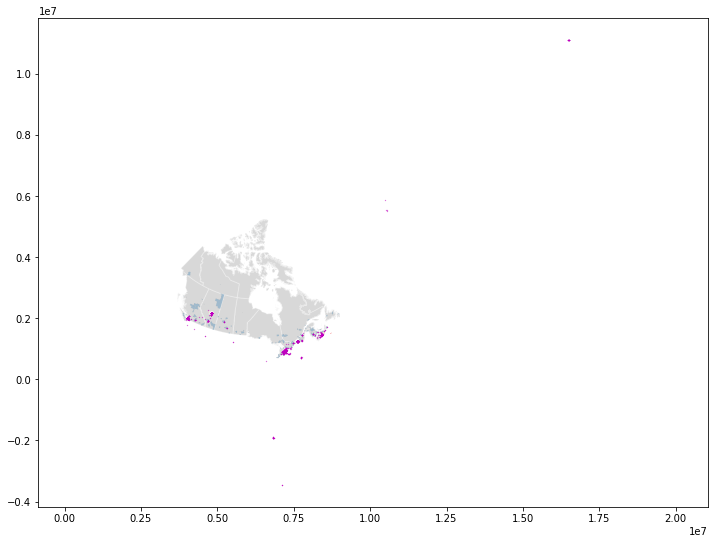

In [36]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,9))
plt.axis('equal')
prov.plot(ax = ax, facecolor = 'grey', edgecolor = 'white', alpha = 0.3)
metropo_all.plot(ax=ax, linewidth = 0.1, edgecolor='grey', alpha = 0.3)
metropo5.plot(ax = ax, color = 'pink', linewidth = 0.2, edgecolor = 'r')
da5.plot(ax=ax,facecolor = 'green', edgecolor = 'white', alpha = 0.3)
actloc_16.plot(ax = ax, marker = 'o', markersize = 0.05, color = 'm')
plt.show()

a number of activity locations fall outides the borders of Canada, and the speicfied 5 metropolitan areas as well.

make sure that DA matches well with CMA boundaries

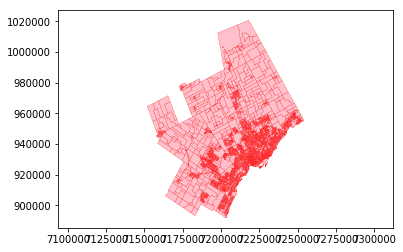

In [37]:
f,ax=plt.subplots(1,1)
plt.axis('equal')
metropo5[metropo5.CMANAME =='Toronto'].plot(ax=ax,facecolor = 'grey', edgecolor = 'white', alpha = 0.3)
da5[da5.CMANAME == 'Toronto'].plot(ax=ax,color = 'pink', linewidth = 0.2, edgecolor = 'r')

### 2. select the activity locations within the residential metropolitan areas
two rules: <br>
ignore the activity locations outside the borders of census tract metropolitan areas of the residential city; <br>
ignore the activity locations outside the boreders of residential metropolitan area yet within the boundaries of other cities (e.g. An Edmontoner visited Toronto)

In [39]:
actloc_sj_Toronto = sjoin(actloc_16, metropo5[metropo5.CMANAME == 'Toronto'], how = 'left', op='within')
actloc_Toronto = actloc_sj_Toronto[actloc_sj_Toronto.S1A_city == actloc_sj_Toronto.CMANAME]
print(actloc_sj_Toronto[actloc_sj_Toronto.CMANAME.isnull() == False].user_id.count()) #2393
print(actloc_sj_Toronto[actloc_sj_Toronto.S1A_city == actloc_sj_Toronto.CMANAME].user_id.count()) #2618
actloc_Toronto

2393
2168


,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,geometry,index_right,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,POINT (7212892.722293774 940406.3008696423),89.0,535,35535,Toronto,B,35,Ontario
5,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,POINT (7212352.01805819 939935.3238804098),89.0,535,35535,Toronto,B,35,Ontario
6,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,POINT (7227856.233284539 931031.3338662987),89.0,535,35535,Toronto,B,35,Ontario
7,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,POINT (7227992.377457372 931172.1832322327),89.0,535,35535,Toronto,B,35,Ontario
8,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,POINT (7228137.124546573 931285.4521353885),89.0,535,35535,Toronto,B,35,Ontario
34,007ECC77-64C2-4E8D-891A-118A942456A2,1,-79.345288,43.679734,0.0,1,5974.964840,Toronto,POINT (7227299.126613609 932271.6345249666),89.0,535,35535,Toronto,B,35,Ontario
35,007ECC77-64C2-4E8D-891A-118A942456A2,2,-79.289213,43.690251,0.0,1,4279.972279,Toronto,POINT (7231604.667276996 934352.5596997994),89.0,535,35535,Toronto,B,35,Ontario
36,007ECC77-64C2-4E8D-891A-118A942456A2,3,-79.342120,43.783126,0.0,1,5601.261511,Toronto,POINT (7225254.749562296 943856.4643598017),89.0,535,35535,Toronto,B,35,Ontario
37,007ECC77-64C2-4E8D-891A-118A942456A2,4,-79.291833,43.689535,0.0,0,0.000000,Toronto,POINT (7231408.541355112 934230.1885969248),89.0,535,35535,Toronto,B,35,Ontario
38,007ECC77-64C2-4E8D-891A-118A942456A2,5,-79.287587,43.688242,0.0,0,0.000000,Toronto,POINT (7231781.146423851 934154.8655972362),89.0,535,35535,Toronto,B,35,Ontario


note that 2393-2168 activity locations in Great Toronto are the points of participants from other cities!

In [41]:
# activity locations in Montreal
actloc_sj_Montreal = sjoin(actloc_16, metropo5[metropo5.CMANAME == 'Montreal'], how = 'left')
actloc_Montreal = actloc_sj_Montreal[actloc_sj_Montreal.S1A_city == actloc_sj_Montreal.CMANAME]
print(actloc_sj_Toronto[actloc_sj_Montreal.CMANAME.isnull() == False].user_id.count()\
     - actloc_sj_Montreal[actloc_sj_Montreal.S1A_city == actloc_sj_Montreal.CMANAME].user_id.count())
# activity locations in Halifax
actloc_sj_Halifax = sjoin(actloc_16, metropo5[metropo5.CMANAME == 'Halifax'], how = 'left')
actloc_Halifax = actloc_sj_Halifax[actloc_sj_Halifax.S1A_city == actloc_sj_Halifax.CMANAME]
print(actloc_sj_Toronto[actloc_sj_Halifax.CMANAME.isnull() == False].user_id.count()\
     - actloc_sj_Halifax[actloc_sj_Halifax.S1A_city == actloc_sj_Halifax.CMANAME].user_id.count())
# activity locations in Vancouver
actloc_sj_Vancouver = sjoin(actloc_16, metropo5[metropo5.CMANAME == 'Vancouver'], how = 'left')
actloc_Vancouver = actloc_sj_Vancouver[actloc_sj_Vancouver.S1A_city == actloc_sj_Vancouver.CMANAME]
print(actloc_sj_Toronto[actloc_sj_Vancouver.CMANAME.isnull() == False].user_id.count()\
     - actloc_sj_Vancouver[actloc_sj_Vancouver.S1A_city == actloc_sj_Vancouver.CMANAME].user_id.count())
# activity locations in Edmonton
actloc_sj_Edmonton = sjoin(actloc_16, metropo5[metropo5.CMANAME == 'Edmonton'], how = 'left')
actloc_Edmonton = actloc_sj_Edmonton[actloc_sj_Edmonton.S1A_city == actloc_sj_Edmonton.CMANAME]
print(actloc_sj_Toronto[actloc_sj_Edmonton.CMANAME.isnull() == False].user_id.count()\
     - actloc_sj_Edmonton[actloc_sj_Edmonton.S1A_city == actloc_sj_Edmonton.CMANAME].user_id.count())

84
35
59
37


concat the activity locations in 5 cities

In [42]:
actloc_5cities = pd.concat([actloc_Toronto,actloc_Montreal,actloc_Halifax,actloc_Vancouver, actloc_Edmonton], axis = 0).\
                 drop(axis=1,columns='index_right')
actloc_5cities #7544 rows × 15 columns

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,geometry,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,POINT (7212892.722293774 940406.3008696423),535,35535,Toronto,B,35,Ontario
5,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,POINT (7212352.01805819 939935.3238804098),535,35535,Toronto,B,35,Ontario
6,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,POINT (7227856.233284539 931031.3338662987),535,35535,Toronto,B,35,Ontario
7,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,POINT (7227992.377457372 931172.1832322327),535,35535,Toronto,B,35,Ontario
8,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,POINT (7228137.124546573 931285.4521353885),535,35535,Toronto,B,35,Ontario
34,007ECC77-64C2-4E8D-891A-118A942456A2,1,-79.345288,43.679734,0.0,1,5974.964840,Toronto,POINT (7227299.126613609 932271.6345249666),535,35535,Toronto,B,35,Ontario
35,007ECC77-64C2-4E8D-891A-118A942456A2,2,-79.289213,43.690251,0.0,1,4279.972279,Toronto,POINT (7231604.667276996 934352.5596997994),535,35535,Toronto,B,35,Ontario
36,007ECC77-64C2-4E8D-891A-118A942456A2,3,-79.342120,43.783126,0.0,1,5601.261511,Toronto,POINT (7225254.749562296 943856.4643598017),535,35535,Toronto,B,35,Ontario
37,007ECC77-64C2-4E8D-891A-118A942456A2,4,-79.291833,43.689535,0.0,0,0.000000,Toronto,POINT (7231408.541355112 934230.1885969248),535,35535,Toronto,B,35,Ontario
38,007ECC77-64C2-4E8D-891A-118A942456A2,5,-79.287587,43.688242,0.0,0,0.000000,Toronto,POINT (7231781.146423851 934154.8655972362),535,35535,Toronto,B,35,Ontario


In [43]:
actloc_5cities.to_file(cs_dir + '/actloc_5cities.shp', driver='ESRI Shapefile')

In [7]:
actloc_5cities = gpd.read_file(cs_dir + '/actloc_5cities.shp')

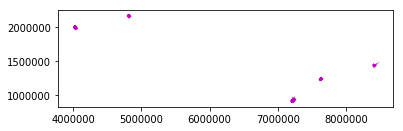

In [8]:
actloc_5cities.plot(color = 'm', marker = 'o', markersize = 0.02)

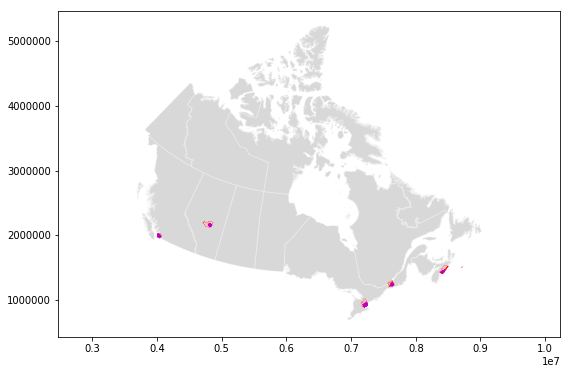

In [9]:
f,ax=plt.subplots(1,1,figsize=(9,6))
prov.plot(ax = ax, facecolor = 'grey', edgecolor = 'white', alpha = 0.3)
metropo5.plot(ax = ax, color = 'pink', linewidth = 0.2, edgecolor = 'r')
actloc_5cities.plot(ax=ax, color = 'm', marker = 'o', markersize = 0.02)
plt.axis('equal')
plt.show()

### 3. derive the measures of density <br> 
### 3.1. attach the dissemination area (DA) id (`DAUID`) to each activity location in `actloc_5cities`

In [50]:
#'DAUID' is the column name of DA id
actloc_5cities = sjoin(actloc_5cities, da5.loc[:,['DAUID','geometry']], how='left').drop(axis=1,columns='index_right')
actloc_5cities.DAUID = actloc_5cities.DAUID.apply(int)
actloc_5cities.head()

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,geometry,DAUID
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,POINT (7212892.722293774 940406.3008696423),35202013
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,POINT (7212352.01805819 939935.3238804098),35202013
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,POINT (7227856.233284539 931031.3338662987),35200703
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,POINT (7227992.377457372 931172.1832322327),35200703
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,POINT (7228137.124546573 931285.4521353885),35200703


In [51]:
actloc_5cities.to_file(cs_dir + 'actloc_5cities.shp', driver='ESRI Shapefile')

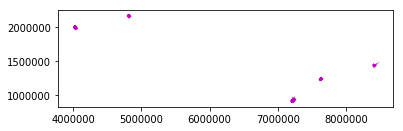

In [52]:
actloc_5cities = gpd.read_file(cs_dir + 'actloc_5cities.shp')
actloc_5cities.plot(color = 'm', marker = 'o', markersize = 0.02)

### 3.2. derive the measure of population density at DA level

check encoding of the population density csv file

In [55]:
with open(cs_dir2 + '2016_PopDenDA.csv') as f:
    print(f)

<_io.TextIOWrapper name='/home/sausy/NB/2016CFS_analysis_190318_Liu_AS/aspatialfiles_CFS16/2016_PopDenDA.csv' mode='r' encoding='UTF-8'>


In [56]:
popden = pd.read_csv(cs_dir2 + '2016_PopDenDA.csv',sep=',',\
                     header=0, index_col=None, encoding='cp1252').\
                     rename(columns={'COL0':'DAUID','COL1':'Province code','COL2':'Province name','COL3':'CD code','COL4':'CD name',\
                             'COL5':'DA name','COL6':'Population2016','COL7':'PopDenKm2','COL8': 'LandAreaKm2'})
popden.head()

,DAUID,Province code,Province name,CD code,CD name,DA name,Population2016,PopDenKm2,LandAreaKm2
0,1209,12,Nova Scotia,9,Halifax,0,403390.0,73.4,5496.31
1,12090103,12,Nova Scotia,9,Halifax,103,714.0,2180.2,0.33
2,12090104,12,Nova Scotia,9,Halifax,104,229.0,2320.2,0.10
3,12090105,12,Nova Scotia,9,Halifax,105,627.0,3157.1,0.20
4,12090106,12,Nova Scotia,9,Halifax,106,269.0,5760.2,0.05


In [57]:
actloc_5cities = actloc_5cities.merge(popden.loc[:,['DAUID','PopDenKm2']], how='left',on = 'DAUID')
actloc_5cities.columns.values[-1]='DA_Popden'
actloc_5cities.head()

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,geometry,DA_Popden
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,POINT (7212892.722293774 940406.3008696423),834.6
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,POINT (7212352.01805819 939935.3238804098),834.6
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,POINT (7227856.233284539 931031.3338662987),6266.1
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,POINT (7227992.377457372 931172.1832322327),6266.1
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,POINT (7228137.124546573 931285.4521353885),6266.1


In [58]:
actloc_5cities.to_file(cs_dir + 'actloc_5cities.shp', driver='ESRI Shapefile')

In [59]:
actloc_5cities = gpd.read_file(cs_dir + 'actloc_5cities.shp')
print(actloc_5cities.shape) #(7544, 17)
actloc_5cities.head()

(7544, 17)


,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,geometry
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,POINT (7212892.722293774 940406.3008696423)
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,POINT (7212352.01805819 939935.3238804098)
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7227856.233284539 931031.3338662987)
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7227992.377457372 931172.1832322327)
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7228137.124546573 931285.4521353885)


### 3.3. merge DA_Storecounts with `actloc_5cities`, calculate DA-level MRFEI and DA-level ratio of fast food stores
output: <br>"actloc_5cities.shp"

In [10]:
actloc_5cities = gpd.read_file(cs_dir + 'actloc_5cities.shp')
actloc_5cities.head()

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRati,int_d,dwl_d,poi,z_int_d,z_dwl_d,z_poi,ale_index,ale_class,transit,z_transit,ale_tranis,ale_transi,geometry
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,117.50000,679.29999,180,1.257652,-0.208820,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,POINT (7212892.722293774 940406.3008696423)
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,117.50000,679.29999,180,1.257652,-0.208820,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,POINT (7212352.01805819 939935.3238804098)
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,POINT (7227856.233284539 931031.3338662987)
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,POINT (7227992.377457372 931172.1832322327)
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,POINT (7228137.124546573 931285.4521353885)


In [61]:
sc = gpd.read_file(cs_dir + '2018Toronto_StoreCountDA/DA_StoreCounts.shp')
sc.DAUID = sc.DAUID.apply(int)
print(sc.columns) #'1km_NUMSup', '1km_NUMFas', '1km_NUMCon', '1km_NUMGre'
sc.head()

Index(['DAUID', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME', 'CDTYPE', 'CCSUID',
       'CCSNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'ERUID', 'ERNAME', 'SACCODE',
       'SACTYPE', 'CMAUID', 'CMAPUID', 'CMANAME', 'CMATYPE', 'CTUID', 'CTNAME',
       'ADAUID', 'CMAUID_2', 'CMAPUID_2', 'CMANAME_2', 'CMATYPE_2', 'PRUID_2',
       'PRNAME_2', '800m_NUMSu', '800m_NUMFa', '800m_NUMCo', '800m_NUMGr',
       '1km_NUMSup', '1km_NUMFas', '1km_NUMCon', '1km_NUMGre', '3km_NUMSup',
       '3km_NUMFas', '3km_NUMCon', '3km_NUMGre', '3kmMRFEI', 'geometry'],
      dtype='object')


,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,CSDTYPE,ERUID,ERNAME,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,CTUID,CTNAME,ADAUID,CMAUID_2,CMAPUID_2,CMANAME_2,CMATYPE_2,PRUID_2,PRNAME_2,800m_NUMSu,800m_NUMFa,800m_NUMCo,800m_NUMGr,1km_NUMSup,1km_NUMFas,1km_NUMCon,1km_NUMGre,3km_NUMSup,3km_NUMFas,3km_NUMCon,3km_NUMGre,3kmMRFEI,geometry
0,10010206,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,CY,1010,Avalon Peninsula,001,1,001,10001,St. John's,B,0010003.02,0003.02,10010015,001,10001,St. John's,B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,0,1,0,0,2,4,3,0,5,28,12,0,0.111,"POLYGON ((8978993.417144999 2148569.774285, 89..."
1,10010207,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,CY,1010,Avalon Peninsula,001,1,001,10001,St. John's,B,0010004.00,0004.00,10010014,001,10001,St. John's,B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1,1,0,0,1,2,0,0,5,28,11,0,0.114,"POLYGON ((8978104.465714999 2148166.911430001,..."
2,10010208,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,CY,1010,Avalon Peninsula,001,1,001,10001,St. John's,B,0010004.00,0004.00,10010014,001,10001,St. John's,B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,0,0,0,0,0,0,0,0,5,28,10,0,0.116,"POLYGON ((8978477.068570003 2150222.668570001,..."
3,10010209,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,CY,1010,Avalon Peninsula,001,1,001,10001,St. John's,B,0010004.00,0004.00,10010014,001,10001,St. John's,B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,3,1,0,0,3,3,0,0,8,28,11,0,0.170,"POLYGON ((8978835.751429997 2149684.359999999,..."
4,10010210,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,CY,1010,Avalon Peninsula,001,1,001,10001,St. John's,B,0010004.00,0004.00,10010014,001,10001,St. John's,B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1,2,0,0,1,2,0,0,7,24,10,0,0.171,"POLYGON ((8979423.968570001 2149862.15143, 897..."


In [62]:
actloc_5cities = actloc_5cities.merge(sc.loc[:,['DAUID','1km_NUMSup', '1km_NUMFas', '1km_NUMCon', '1km_NUMGre']], how='left', on='DAUID')
print(actloc_5cities.shape) #(4898, 20)
actloc_5cities.rename(columns={'1km_NUMSup':'DA1kmSup', '1km_NUMFas':'DA1kmFas',\
                               '1km_NUMCon':'DA1kmCon', '1km_NUMGre':'DA1kmGre'}, inplace=True)
actloc_5cities.head() #(7544, 21)

(7544, 21)


,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,geometry,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,POINT (7212892.722293774 940406.3008696423),0,30,6,0
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,POINT (7212352.01805819 939935.3238804098),0,30,6,0
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7227856.233284539 931031.3338662987),3,10,11,1
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7227992.377457372 931172.1832322327),3,10,11,1
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7228137.124546573 931285.4521353885),3,10,11,1


In [63]:
actloc_5cities['DA_MRFEI']= (actloc_5cities['DA1kmFas']+actloc_5cities['DA1kmCon'])/(actloc_5cities['DA1kmSup']+actloc_5cities['DA1kmFas']+actloc_5cities['DA1kmCon']+actloc_5cities['DA1kmGre'])
actloc_5cities['DA_fasRatio']= actloc_5cities['DA1kmFas']/(actloc_5cities['DA1kmSup']+actloc_5cities['DA1kmFas']+actloc_5cities['DA1kmCon']+actloc_5cities['DA1kmGre'])
actloc_5cities.head()

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,geometry,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRatio
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,POINT (7212892.722293774 940406.3008696423),0,30,6,0,1.00,0.833333
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,POINT (7212352.01805819 939935.3238804098),0,30,6,0,1.00,0.833333
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7227856.233284539 931031.3338662987),3,10,11,1,0.84,0.400000
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7227992.377457372 931172.1832322327),3,10,11,1,0.84,0.400000
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,POINT (7228137.124546573 931285.4521353885),3,10,11,1,0.84,0.400000


In [64]:
actloc_5cities.to_file(cs_dir + 'actloc_5cities.shp', driver='ESRI Shapefile')

In [ ]:
actloc_5cities = gpd.read_file(cs_dir + 'actloc_5cities.shp')
print(actloc_5cities.shape) #(7544, 23)
actloc_5cities.head()

### 3.4. link the DA-level measures intersection density, dwelling density, number of POI, number of transit stops, ALE index, ALE_transit index from 2016 Can ALE dataset to activity locations <br>
output: "actloc_5cities.shp"

In [66]:
CanALE = pd.read_csv(cs_dir2 + 'CanALE_2016.csv', sep = ',', header = 0, index_col = None)
print(CanALE.shape)
CanALE.head()

(56589, 13)


,dauid,int_d,dwl_d,poi,z_int_d,z_dwl_d,z_poi,ale_index,ale_class,transit,z_transit,ale_tranist,ale_transit_class
0,10010165,37.099998,700.90002,50,-0.214259,-0.19163157,-0.046611,-0.45250192,2,45,-0.0545245,-0.4932068,2
1,10010166,40.000000,748.40002,52,-0.161168,-0.15383206,-0.029199,-0.34419867,2,46,-0.023959989,-0.35378754,2
2,10010167,44.500000,869.20001,54,-0.078785,-0.057701942,-0.011786,-0.14827305,2,51,0.12886257,-0.00448783,2
3,10010168,59.200001,1056,61,0.190333,0.090949602,0.049157,0.33044004,3,60,0.40394318,0.7512362,2
4,10010169,53.200001,991.59998,58,0.080489,0.039701425,0.023039,0.14322911,3,53,0.18999159,0.34924641,2


In [67]:
actloc_5cities = gpd.read_file(cs_dir + 'actloc_5cities.shp')
actloc_5cities.head()

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRati,geometry
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,POINT (7212892.722293774 940406.3008696423)
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,POINT (7212352.01805819 939935.3238804098)
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,POINT (7227856.233284539 931031.3338662987)
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,POINT (7227992.377457372 931172.1832322327)
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,POINT (7228137.124546573 931285.4521353885)


In [68]:
actloc_5cities = actloc_5cities.join(CanALE.set_index('dauid'),on='DAUID', how='left')
print(actloc_5cities.shape) #(7544, 35)
actloc_5cities.head()

(7544, 35)


,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRati,geometry,int_d,dwl_d,poi,z_int_d,z_dwl_d,z_poi,ale_index,ale_class,transit,z_transit,ale_tranist,ale_transit_class
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,POINT (7212892.722293774 940406.3008696423),117.50000,679.29999,180,1.257652,-0.2088204,1.085197,2.134028,2,63,0.4956367,2.679333,2
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,POINT (7212352.01805819 939935.3238804098),117.50000,679.29999,180,1.257652,-0.2088204,1.085197,2.134028,2,63,0.4956367,2.679333,2
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,POINT (7227856.233284539 931031.3338662987),141.89999,3919.3999,162,1.704351,2.3695836,0.928485,5.0024195,5,78,0.95410436,6.0012283,5
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,POINT (7227992.377457372 931172.1832322327),141.89999,3919.3999,162,1.704351,2.3695836,0.928485,5.0024195,5,78,0.95410436,6.0012283,5
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,POINT (7228137.124546573 931285.4521353885),141.89999,3919.3999,162,1.704351,2.3695836,0.928485,5.0024195,5,78,0.95410436,6.0012283,5


In [69]:
actloc_5cities.loc[:,['int_d','dwl_d','poi','z_int_d','z_dwl_d','z_poi','ale_index','ale_class',\
            'transit','z_transit','ale_tranist','ale_transit_class']] = \
            actloc_5cities.loc[:,['int_d','dwl_d','poi','z_int_d','z_dwl_d','z_poi','ale_index','ale_class',\
            'transit','z_transit','ale_tranist','ale_transit_class']].convert_objects(convert_numeric=True)

/home/sausy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use GeoDataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


In [70]:
actloc_5cities.ale_index.dtype

dtype('float64')

In [71]:
actloc_5cities.to_file(cs_dir + 'actloc_5cities.shp', driver = 'ESRI Shapefile')

In [12]:
actloc_5cities = gpd.read_file(cs_dir + 'actloc_5cities.shp')
print(actloc_5cities.shape) #(7544, 35)
actloc_5cities.head()

(7544, 35)


,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRati,int_d,dwl_d,poi,z_int_d,z_dwl_d,z_poi,ale_index,ale_class,transit,z_transit,ale_tranis,ale_transi,geometry
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,117.50000,679.29999,180,1.257652,-0.208820,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,POINT (7212892.722293774 940406.3008696423)
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,117.50000,679.29999,180,1.257652,-0.208820,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,POINT (7212352.01805819 939935.3238804098)
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,POINT (7227856.233284539 931031.3338662987)
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,POINT (7227992.377457372 931172.1832322327)
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,POINT (7228137.124546573 931285.4521353885)


### 3.5. calculate the time-weighted DA-level population density, MRFEI, ratio of fast food stores, ale_index, ale_tranis by `pivot_table` <br>
output: "2016CFS_S1A_twPopdenRelaAle_20181129_Liu.csv" 

merge `pct_actdura` with `actloc_5cities`

In [73]:
loca2 = pd.read_csv(cs_dir2 + 'CFS16_locapct.csv', index_col= None, header = 0)
print(loca2.shape) #(8708, 9)
loca2.head()

(8708, 9)


,user_id,location_id,lon,lat,description,used,duration,sum_actdura,pct_actdura
0,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,1,-73.575378,45.508685,NaN,True,15130.723035,9790.287797,0.025758
1,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,2,-73.606781,45.475646,NaN,True,5369.127641,9790.287797,0.009140
2,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,3,-73.607132,45.526881,NaN,True,356943.703181,9790.287797,0.607649
3,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,4,-73.598830,45.520727,NaN,False,0.000000,9790.287797,0.000000
4,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,5,-73.609740,45.525461,NaN,False,0.000000,9790.287797,0.000000


In [74]:
actloc_pct = pd.merge(actloc_5cities, loca2[['user_id','location_id','sum_actdura','pct_actdura']],  how='left',\
                          left_on=['user_id','location_i'], right_on = ['user_id','location_id'])

In [75]:
actloc_pct.to_file(cs_dir + 'actloc_pct.shp', driver = 'ESRI Shapefile')

In [13]:
actloc_pct = gpd.read_file(cs_dir + 'actloc_pct.shp')
print(actloc_pct.shape) #(7544, 38)
actloc_pct.head()

(7544, 38)


,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRati,int_d,dwl_d,poi,z_int_d,z_dwl_d,z_poi,ale_index,ale_class,transit,z_transit,ale_tranis,ale_transi,location_1,sum_actdur,pct_actdur,geometry
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,117.50000,679.29999,180,1.257652,-0.208820,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,1,9822.612842,0.00000,POINT (7212892.722293774 940406.3008696423)
1,29c1b8c3-13fa-438c-bcef-b3386e3543d7,2,-79.504967,43.771359,0.0,1,14828.164194,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.00,0.833333,117.50000,679.29999,180,1.257652,-0.208820,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,2,9822.612842,0.02516,POINT (7212352.01805819 939935.3238804098)
2,29c1b8c3-13fa-438c-bcef-b3386e3543d7,3,-79.341610,43.668086,0.0,0,0.000000,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,3,9822.612842,0.00000,POINT (7227856.233284539 931031.3338662987)
3,29c1b8c3-13fa-438c-bcef-b3386e3543d7,4,-79.339660,43.669065,0.0,1,4225.763820,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,4,9822.612842,0.00717,POINT (7227992.377457372 931172.1832322327)
4,29c1b8c3-13fa-438c-bcef-b3386e3543d7,5,-79.337673,43.669793,0.0,1,570302.842476,Toronto,535,35535,Toronto,B,35,Ontario,35200703,6266.1,3,10,11,1,0.84,0.400000,141.89999,3919.39990,162,1.704351,2.369584,0.928485,5.002420,5.0,78,0.954104,6.001228,5.0,5,9822.612842,0.96767,POINT (7228137.124546573 931285.4521353885)


calculate the time-weighted population density, MRFEI, and ratio of fast food stores by `pivot_table`

In [77]:
actloc_pct['dur*Popden']=actloc_pct.pct_actdur*actloc_pct.DA_Popden
actloc_pct['dur*MRFEI']=actloc_pct.pct_actdur*actloc_pct.DA_MRFEI
actloc_pct['dur*fasrati']=actloc_pct.pct_actdur*actloc_pct.DA_fasRati
actloc_pct['dur*ale']=actloc_pct.pct_actdur*actloc_pct.ale_index
actloc_pct['dur*aletran'] = actloc_pct.pct_actdur*actloc_pct.ale_tranis

In [78]:
actloc_pct.ix[:,['used','pct_actdur','DA_Popden','DA_MRFEI', 'DA_fasRati','dur*Popden','dur*MRFEI','dur*fasrati','dur*ale','dur*aletran']].head()

/home/sausy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,used,pct_actdur,DA_Popden,DA_MRFEI,DA_fasRati,dur*Popden,dur*MRFEI,dur*fasrati,dur*ale,dur*aletran
0,0,0.00000,834.6,1.00,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.02516,834.6,1.00,0.833333,20.998462,0.025160,0.020967,0.053692,0.067412
2,0,0.00000,6266.1,0.84,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,0.00717,6266.1,0.84,0.400000,44.928743,0.006023,0.002868,0.035868,0.043030
4,1,0.96767,6266.1,0.84,0.400000,6063.516736,0.812843,0.387068,4.840691,5.807208


In [80]:
pt = actloc_pct.pivot_table(values=['dur*Popden','dur*MRFEI','dur*fasrati','dur*ale','dur*aletran'],\
                            index='user_id', columns=None, aggfunc='sum')

pt.columns = ['DAtwMRFEI','DAtwPopden','DAtwALE','DAtwALEtransit','DAtwFaspct']
pt.head()

,DAtwMRFEI,DAtwPopden,DAtwALE,DAtwALEtransit,DAtwFaspct
user_id,,,,,
0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,0.705199,14352.853526,6.586035,7.692473,0.294767
007ECC77-64C2-4E8D-891A-118A942456A2,0.856262,211333.758930,4.936294,5.955051,0.434249
00B10D83-05EF-4970-8BBC-4D53424D88FD,0.751645,3371.626896,0.658079,1.106917,0.464422
00E42A36-FD6B-4C5E-81A7-77D302393165,0.768595,6522.391666,2.317619,3.250214,0.456037
010A29F6-C494-4E13-864D-DA8B2BE1C517,0.768965,6499.237021,3.882207,4.127774,0.693584


In [81]:
pt.to_csv(cs_dir2 + 'CFS16_twDenFas.csv',sep=',',header=True,index=True)

In [13]:
pd.read_csv(cs_dir2 + 'CFS16_twDenFas.csv',sep=',',header=0,index_col=None).head()

,user_id,DAtwMRFEI,DAtwPopden,DAtwALE,DAtwALEtransit,DAtwFaspct
0,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,0.705199,14352.853526,6.586035,7.692473,0.294767
1,007ECC77-64C2-4E8D-891A-118A942456A2,0.856262,211333.758930,4.936294,5.955051,0.434249
2,00B10D83-05EF-4970-8BBC-4D53424D88FD,0.751645,3371.626896,0.658079,1.106917,0.464422
3,00E42A36-FD6B-4C5E-81A7-77D302393165,0.768595,6522.391666,2.317619,3.250214,0.456037
4,010A29F6-C494-4E13-864D-DA8B2BE1C517,0.768965,6499.237021,3.882207,4.127774,0.693584


### 5. buffer (with a radius of 500m, 1000m, 1500m) the activity locations

directly assign the buffer as the geometry column, which replaces the original point geometry, <font color = 'blue'> to maintain the attributes of actloc GeoDataFrame </font> <br> 
https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe/253387 <br>
<font color = 'red'>when I apply buffer to buf_500m, I found that actloc_5cities changed to polygons?? confused</font>

In [14]:
actloc_pct = gpd.read_file(cs_dir + 'actloc_pct.shp')
print(actloc_pct.shape) #(7544, 38)

(7544, 38)


In [15]:
buf_500m = actloc_pct
buf_500m['geometry'] = buf_500m.geometry.buffer(distance = 500)

In [16]:
actloc_pct = gpd.read_file(cs_dir + 'actloc_pct.shp')
print(actloc_pct.shape) #(7544, 38)

(7544, 38)


In [17]:
buf_1000m = actloc_pct
buf_1000m['geometry'] = buf_1000m.geometry.buffer(distance = 1000)

In [18]:
actloc_pct = gpd.read_file(cs_dir + 'actloc_pct.shp')
print(actloc_pct.shape) #(7544, 38)

(7544, 38)


In [19]:
buf_1500m = actloc_pct
buf_1500m['geometry'] = buf_1500m.geometry.buffer(distance = 1500)

In [20]:
actloc_pct = gpd.read_file(cs_dir + 'actloc_pct.shp')
print(actloc_pct.shape) #(7544, 38)

(7544, 38)


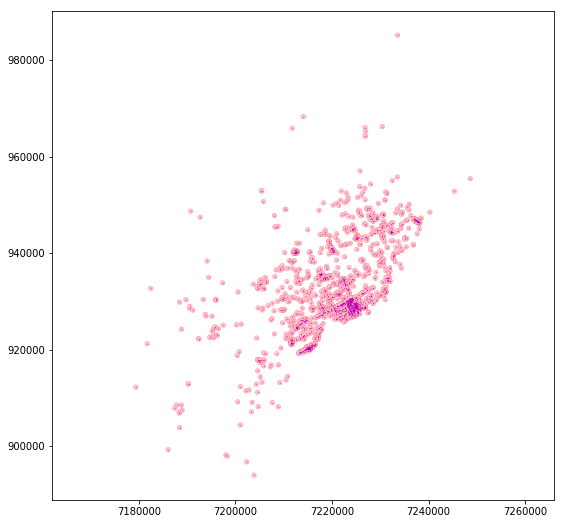

In [21]:
f,ax = plt.subplots(1,1, figsize = (9,9))
#metropo5[metropo5.CMANAME == 'Toronto'].plot(ax = ax, facecolor = 'grey', edgecolor = 'black', alpha = 0.3)
buf_500m[buf_500m.S1A_city == 'Toronto'].plot(ax = ax, facecolor = 'pink', edgecolor = 'r', linewidth = 0.1)
actloc_pct[actloc_pct.S1A_city == 'Toronto'].plot(ax=ax, color = 'm', marker = 'o', markersize = 0.03)
plt.axis('equal')
plt.show()

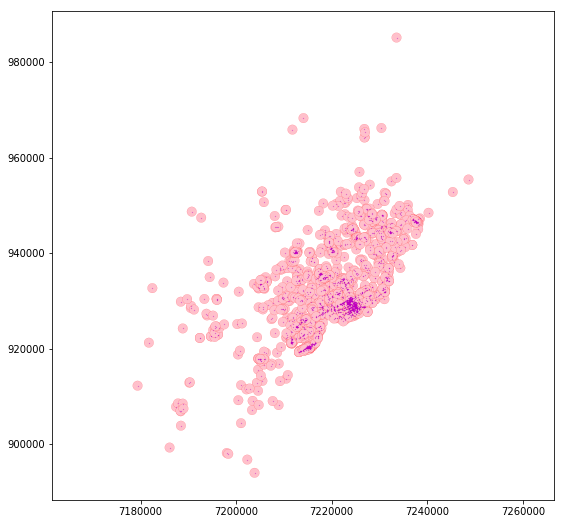

In [22]:
f,ax = plt.subplots(1,1, figsize = (9,9))
#metropo5[metropo5.CMANAME == 'Toronto'].plot(ax = ax, facecolor = 'grey', edgecolor = 'black', alpha = 0.3)
buf_1000m[buf_1000m.S1A_city == 'Toronto'].plot(ax = ax, facecolor = 'pink', edgecolor = 'r', linewidth = 0.1)
actloc_pct[actloc_pct.S1A_city == 'Toronto'].plot(ax=ax, color = 'm', marker = 'o', markersize = 0.03)
plt.axis('equal')
plt.show()

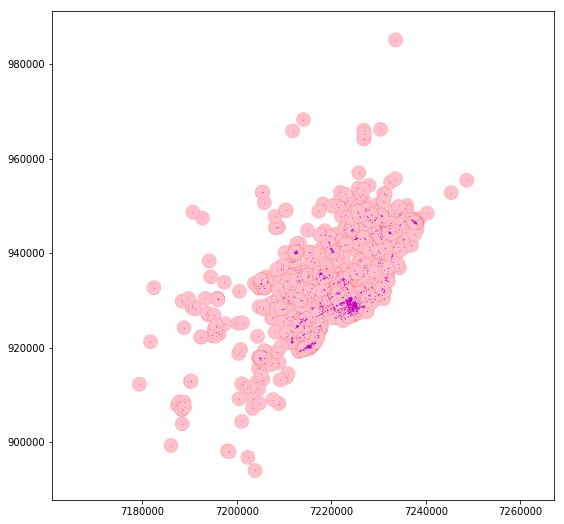

In [23]:
f,ax = plt.subplots(1,1, figsize = (9,9))
#metropo5[metropo5.CMANAME == 'Toronto'].plot(ax = ax, facecolor = 'grey', edgecolor = 'black', alpha = 0.3)
buf_1500m[buf_1500m.S1A_city == 'Toronto'].plot(ax = ax, facecolor = 'pink', edgecolor = 'r', linewidth = 0.1)
actloc_pct[actloc_pct.S1A_city == 'Toronto'].plot(ax=ax, color = 'm', marker = 'o', markersize = 0.03)
plt.axis('equal')
plt.show()

### 4. load fast food restaurants

In [24]:
sup = gpd.read_file(cs_dir + '2018_MRFEI_points/supermarket3.shp').to_crs(prov.crs)
con = gpd.read_file(cs_dir + '2018_MRFEI_points/convenience2.shp').to_crs(prov.crs)
fas = gpd.read_file(cs_dir + '2018_MRFEI_points/fast_food2.shp').to_crs(prov.crs)
gre = gpd.read_file(cs_dir + '2018_MRFEI_points/greengrocer2.shp').to_crs(prov.crs)

how to create subplots with several rows and columns <br> 
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html

In [25]:
metropo5.crs = prov.crs

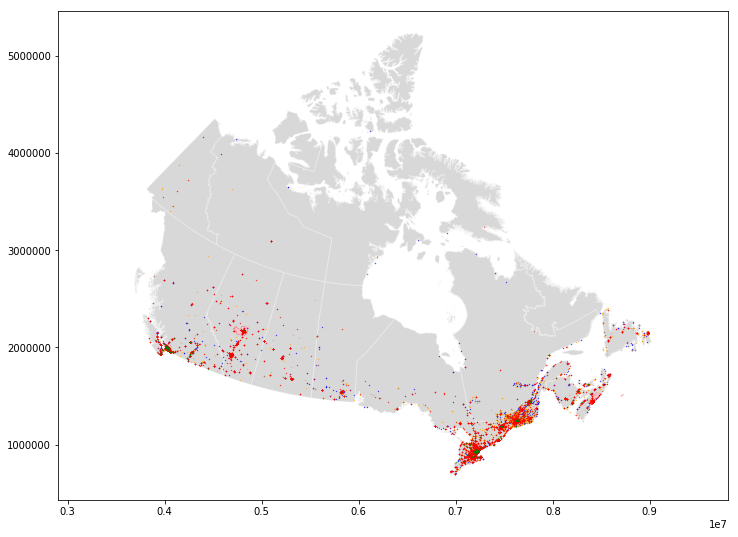

In [26]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,9))
plt.axis('equal')
prov.plot(ax = ax, facecolor = 'grey', edgecolor = 'white', alpha = 0.3)
#metropo_all.plot(ax=ax, linewidth = 0.1, edgecolor='grey', alpha = 0.3)
metropo5.plot(ax = ax, color = 'pink', linewidth = 0.2, edgecolor = 'r', alpha =0.8)
sup.plot(ax=ax, color='blue', marker = 'o', markersize = 0.1)
con.plot(ax=ax, color='orange', marker = 'o', markersize = 0.1)
fas.plot(ax=ax, color='red', marker = 'o', markersize = 0.1)
gre.plot(ax=ax, color='green', marker = 'o', markersize = 0.1)
plt.show()

In [27]:
sup5 = sjoin(sup, metropo5.loc[:,['CMANAME','geometry']], how='left').drop(axis=1,columns='index_right')
con5 = sjoin(con, metropo5.loc[:,['CMANAME','geometry']], how='left').drop(axis=1,columns='index_right')
fas5 = sjoin(fas, metropo5.loc[:,['CMANAME','geometry']], how='left').drop(axis=1,columns='index_right')
gre5 = sjoin(gre, metropo5.loc[:,['CMANAME','geometry']], how='left').drop(axis=1,columns='index_right')
sup5 = sup5[(sup5.CMANAME == 'Halifax') | (sup5.CMANAME == 'Montreal') | (sup5.CMANAME == 'Toronto') | (sup5.CMANAME == 'Edmonton') | (sup5.CMANAME == 'Vancouver')]
con5 = con5[(con5.CMANAME == 'Halifax') | (con5.CMANAME == 'Montreal') | (con5.CMANAME == 'Toronto') | (con5.CMANAME == 'Edmonton') | (con5.CMANAME == 'Vancouver')]
fas5 = fas5[(fas5.CMANAME == 'Halifax') | (fas5.CMANAME == 'Montreal') | (fas5.CMANAME == 'Toronto') | (fas5.CMANAME == 'Edmonton') | (fas5.CMANAME == 'Vancouver')]
gre5 = gre5[(gre5.CMANAME == 'Halifax') | (gre5.CMANAME == 'Montreal') | (gre5.CMANAME == 'Toronto') | (gre5.CMANAME == 'Edmonton') | (gre5.CMANAME == 'Vancouver')]

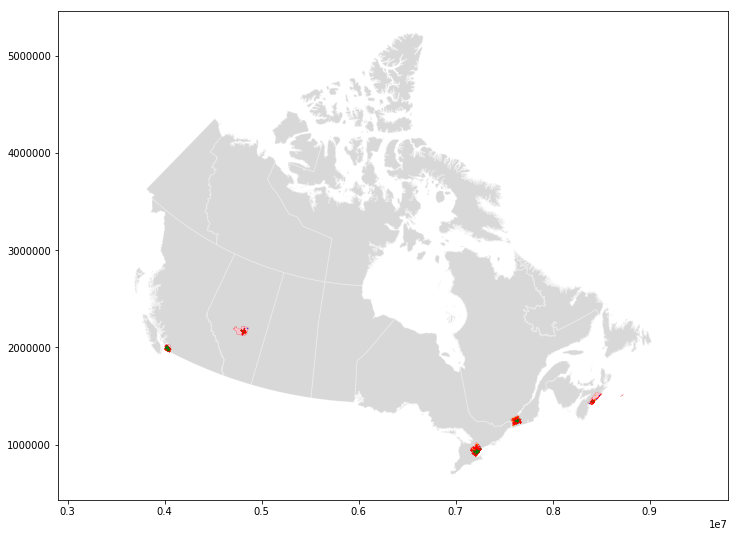

In [28]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,9))
plt.axis('equal')
prov.plot(ax = ax, facecolor = 'grey', edgecolor = 'white', alpha = 0.3)
#metropo_all.plot(ax=ax, linewidth = 0.1, edgecolor='grey', alpha = 0.3)
metropo5.plot(ax = ax, color = 'pink', linewidth = 0.2, edgecolor = 'r', alpha =0.8)
sup5.plot(ax=ax, color='blue', marker = 'o', markersize = 0.1)
con5.plot(ax=ax, color='orange', marker = 'o', markersize = 0.1)
fas5.plot(ax=ax, color='red', marker = 'o', markersize = 0.1)
gre5.plot(ax=ax, color='green', marker = 'o', markersize = 0.1)
plt.show()

map the activity locations, activity spaces (buffer areas), and fast food restaurants in each of the 5 cities <br>
<font color='red'>how to plot the fast food outlets in Toronto using contains function? </font>

### 5. assign the buf_500m attributes to fast food restaurants intersecting with it using spatialjoin

the dataframs for sjoin function cannot include column name 'index_left' and 'index_right' <br>
ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [29]:
buf_500m.head(1)

,user_id,location_i,lon,lat,descriptio,used,duration,S1A_city,CMAUID,CMAPUID,CMANAME,CMATYPE,PRUID,PRNAME,DAUID,DA_Popden,DA1kmSup,DA1kmFas,DA1kmCon,DA1kmGre,DA_MRFEI,DA_fasRati,int_d,dwl_d,poi,z_int_d,z_dwl_d,z_poi,ale_index,ale_class,transit,z_transit,ale_tranis,ale_transi,location_1,sum_actdur,pct_actdur,geometry
0,29c1b8c3-13fa-438c-bcef-b3386e3543d7,1,-79.497425,43.774504,0.0,0,0.0,Toronto,535,35535,Toronto,B,35,Ontario,35202013,834.6,0,30,6,0,1.0,0.833333,117.5,679.29999,180,1.257652,-0.20882,1.085197,2.134028,2.0,63,0.495637,2.679333,2.0,1,9822.612842,0.0,"POLYGON ((7213392.722293774 940406.3008696423,..."


In [30]:
buf_500m.crs = prov.crs
buf_1000m.crs = prov.crs
buf_1500m.crs = prov.crs

In [31]:
sup_500 = sjoin(sup5,buf_500m, how = 'left')
con_500 = sjoin(con5,buf_500m, how = 'left')
fas_500 = sjoin(fas5,buf_500m, how = 'left')
gre_500 = sjoin(gre5,buf_500m, how = 'left')
sup_1000 = sjoin(sup5,buf_1000m, how = 'left')
con_1000 = sjoin(con5,buf_1000m, how = 'left')
fas_1000 = sjoin(fas5,buf_1000m, how = 'left')
gre_1000 = sjoin(gre5,buf_1000m, how = 'left')
sup_1500 = sjoin(sup5,buf_1500m, how = 'left')
con_1500 = sjoin(con5,buf_1500m, how = 'left')
fas_1500 = sjoin(fas5,buf_1500m, how = 'left')
gre_1500 = sjoin(gre5,buf_1500m, how = 'left')

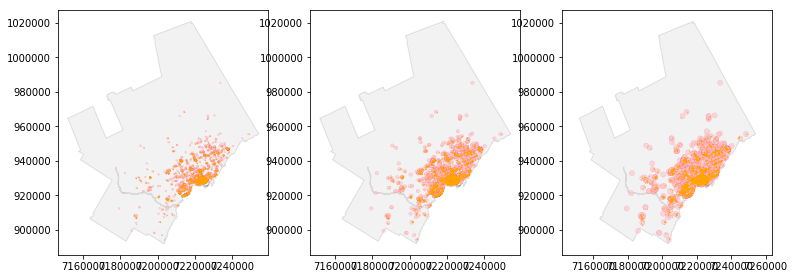

In [32]:
f, (ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize = (12.8,4.5)) #gridspec_kw={'width_ratios':[1,1,1]}

metropo5[metropo5.CMANAME == 'Toronto'].plot(ax=ax1, facecolor = 'grey', edgecolor = 'black', alpha = 0.1)
buf_500m[buf_500m.S1A_city == 'Toronto'].plot(ax=ax1, facecolor = 'pink', edgecolor = 'red', linewidth = 0.1, alpha = 0.6)
#sup_500[sup_500.S1A_city == 'Toronto'].plot(ax=ax1, color = 'orange' , marker = '.', markersize = 0.02)
#con_500[con_500.S1A_city == 'Toronto'].plot(ax=ax1, color = 'orange' , marker = '.', markersize = 0.02)
fas_500[fas_500.S1A_city == 'Toronto'].plot(ax=ax1, color = 'orange' , marker = '.', markersize = 0.02)
#gre_500[gre_500.S1A_city == 'Toronto'].plot(ax=ax1, color = 'orange' , marker = '.', markersize = 0.02)


metropo5[metropo5.CMANAME == 'Toronto'].plot(ax=ax2, facecolor = 'grey', edgecolor = 'black', alpha = 0.1)
buf_1000m[buf_1000m.S1A_city == 'Toronto'].plot(ax=ax2, facecolor = 'pink', edgecolor = 'red', linewidth = 0.1, alpha = 0.6)
sup_1000[sup_1000.S1A_city == 'Toronto'].plot(ax=ax2, color = 'orange' , marker = '.', markersize = 0.02)
#con_1000[con_1000.S1A_city == 'Toronto'].plot(ax=ax2, color = 'orange' , marker = '.', markersize = 0.02)
fas_1000[fas_1000.S1A_city == 'Toronto'].plot(ax=ax2, color = 'orange' , marker = '.', markersize = 0.02)
#gre_1000[gre_1000.S1A_city == 'Toronto'].plot(ax=ax2, color = 'orange' , marker = '.', markersize = 0.02)

metropo5[metropo5.CMANAME == 'Toronto'].plot(ax=ax3, facecolor = 'grey', edgecolor = 'black', alpha = 0.1)
buf_1500m[buf_1500m.S1A_city == 'Toronto'].plot(ax=ax3, facecolor = 'pink', edgecolor = 'red', linewidth = 0.1, alpha = 0.6)
#sup_1500[sup_1500.S1A_city == 'Toronto'].plot(ax=ax3, color = 'orange' , marker = '.', markersize = 0.02)
#con_1500[con_1500.S1A_city == 'Toronto'].plot(ax=ax3, color = 'orange' , marker = '.', markersize = 0.02)
fas_1500[fas_1500.S1A_city == 'Toronto'].plot(ax=ax3, color = 'orange' , marker = '.', markersize = 0.02)
#gre_1500[gre_1500.S1A_city == 'Toronto'].plot(ax=ax3, color = 'orange' , marker = '.', markersize = 0.02)

plt.axis('equal')
plt.show()

### 6. aggregate supermarket, convenience, fast food, green grocery by each participant
### calculate Ratio of fast food stores

calculate time-weighted ratio of fast food stores

In [33]:
numsup500_act = sup_500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numsup500_act.columns = ['numsup500_act']
numcon500_act = con_500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numcon500_act.columns = ['numcon500_act']
numfas500_act = fas_500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numfas500_act.columns = ['numfas500_act']
numgre500_act = gre_500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numgre500_act.columns = ['numgre500_act']
numfas500_act

numsup1000_act = sup_1000.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numsup1000_act.columns = ['numsup1000_act']
numcon1000_act = con_1000.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numcon1000_act.columns = ['numcon1000_act']
numfas1000_act = fas_1000.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numfas1000_act.columns = ['numfas1000_act']
numgre1000_act = gre_1000.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numgre1000_act.columns = ['numgre1000_act']
numfas1000_act

numsup1500_act = sup_1500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numsup1500_act.columns = ['numsup1500_act']
numcon1500_act = con_1500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numcon1500_act.columns = ['numcon1500_act']
numfas1500_act = fas_1500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numfas1500_act.columns = ['numfas1500_act']
numgre1500_act = gre_1500.groupby(by=['user_id','location_i']).aggregate({'user_id':'count'})
numgre1500_act.columns = ['numgre1500_act']
numfas1500_act

numfas1500_act
user_id                              location_i                
0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9 1.0                     92
                                     2.0                     10
                                     3.0                     29
                                     4.0                     35
                                     5.0                     27
                                     6.0                     16
                                     7.0                      6
                                     8.0                     20
                                     9.0                     27
                                     10.0                    75
                                     11.0                    64
                                     12.0                    12
                                     13.0                    10
                                     14.0                    79
                                     15.0                    34
                                     16.0                    15
007ECC77-64C2-4E8D-891A-118A942456A2 1.0                     24
                                     2.0                     16
                                     3.0                     22
                                     4.0                     16
                                     5.0                     15
                                     6.0                     15
                                     7.0                     29
                                     8.0                     30
                                     9.0                     15
                                     10.0                    85
                                     11.0                   112
                                     12.0                    28
00B10D83-05EF-4970-8BBC-4D53424D88FD 1.0                      3
                                     2.0                      1
...                                                         ...
fb3c7f7f-a43f-4052-9b75-ae1b903b3c2b 20.0                    12
                                     21.0                    17
                                     22.0                   360
                                     23.0                    30
                                     24.0                     7
                                     25.0                   413
                                     26.0                    16
                                     27.0                   286
fc43822f-026d-4006-b4eb-c701a8cd03f7 1.0                     13
                                     2.0                     13
                                     3.0                     13
                                     4.0                     13
                                     5.0                     14
                                     6.0                     11
                                     7.0                     13
                                     8.0                     13
                                     9.0                     13
                                     10.0                     1
                                     11.0                    13
                                     12.0                     5
fd450da9-4278-4f20-925e-6a4e3a73774d 1.0                     30
                                     2.0                     31
                                     3.0                      6
                                     4.0                      8
                                     5.0                      6
                                     6.0                      9
                                     7.0                     28
                                     8.0                     31
                                     9.0                     31
                                     10.0                    15

[7288 rows x 1 c

In [34]:
num500join = numsup500_act.join([numcon500_act,numfas500_act,numgre500_act], how='outer')
num500join.fillna(0, inplace=True)
num500join['fasRatio'] = num500join['numfas500_act']/(num500join['numsup500_act']+num500join['numcon500_act']+\
                         num500join['numfas500_act']+num500join['numgre500_act'])
num500join = num500join.join(buf_500m[['user_id','location_i','pct_actdur']].set_index(['user_id','location_i']), how='left')
num500join['twfasRa500'] = num500join['fasRatio'] * num500join['pct_actdur']
twfasRa500 = num500join.groupby(by='user_id', axis=0).aggregate({'twfasRa500':'sum'})
twfasRa500

num1000join = numsup1000_act.join([numcon1000_act,numfas1000_act,numgre1000_act], how='outer')
num1000join.fillna(0, inplace=True)
num1000join['fasRatio'] = num1000join['numfas1000_act']/(num1000join['numsup1000_act']+num1000join['numcon1000_act']+\
                         num1000join['numfas1000_act']+num1000join['numgre1000_act'])
num1000join = num1000join.join(buf_1000m[['user_id','location_i','pct_actdur']].set_index(['user_id','location_i']), how='left')
num1000join['twfasRa1000'] = num1000join['fasRatio'] * num1000join['pct_actdur']
twfasRa1000 = num1000join.groupby(by='user_id', axis=0).aggregate({'twfasRa1000':'sum'})
twfasRa1000

num1500join = numsup1500_act.join([numcon1500_act,numfas1500_act,numgre1500_act], how='outer')
num1500join.fillna(0, inplace=True)
num1500join['fasRatio'] = num1500join['numfas1500_act']/(num1500join['numsup1500_act']+num1500join['numcon1500_act']+\
                         num1500join['numfas1500_act']+num1500join['numgre1500_act'])
num1500join = num1500join.join(buf_1500m[['user_id','location_i','pct_actdur']].set_index(['user_id','location_i']), how='left')
num1500join['twfasRa1500'] = num1500join['fasRatio'] * num1500join['pct_actdur']
twfasRa1500 = num1500join.groupby(by='user_id', axis=0).aggregate({'twfasRa1500':'sum'})
twfasRa1500

,twfasRa1500
user_id,
0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,0.370307
007ECC77-64C2-4E8D-891A-118A942456A2,0.456462
00B10D83-05EF-4970-8BBC-4D53424D88FD,0.591368
00E42A36-FD6B-4C5E-81A7-77D302393165,0.600496
010A29F6-C494-4E13-864D-DA8B2BE1C517,0.668889
014B4AFB-0BDA-458B-BF15-AD1358EF9A84,0.489021
01ec0a68-2787-47dc-a0d5-e046f682b0d6,0.761546
02005963-f1db-4dbe-b08c-922646c33c54,0.343591
0213B5AD-A501-495D-AF14-18569C4A6337,0.592777


In [35]:
twfasRatio = twfasRa500.join([twfasRa1000, twfasRa1500], how='left')
twfasRatio

,twfasRa500,twfasRa1000,twfasRa1500
user_id,,,
0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,0.426911,0.285837,0.370307
007ECC77-64C2-4E8D-891A-118A942456A2,0.043325,0.481646,0.456462
00B10D83-05EF-4970-8BBC-4D53424D88FD,0.064806,0.475046,0.591368
00E42A36-FD6B-4C5E-81A7-77D302393165,0.436282,0.531333,0.600496
010A29F6-C494-4E13-864D-DA8B2BE1C517,0.638524,0.734479,0.668889
014B4AFB-0BDA-458B-BF15-AD1358EF9A84,0.630839,0.516178,0.489021
01ec0a68-2787-47dc-a0d5-e046f682b0d6,0.188387,0.774687,0.761546
02005963-f1db-4dbe-b08c-922646c33c54,0.199584,0.077821,0.343591
0213B5AD-A501-495D-AF14-18569C4A6337,0.623232,0.602610,0.592777


calculate number and time-weighted number of fast food stores

In [36]:
numsup500 = sup_500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numsup500.columns = ['numsup500']
numcon500 = con_500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numcon500.columns = ['numcon500']
numfas500 = fas_500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numfas500.columns = ['numfas500']
numgre500 = gre_500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numgre500.columns = ['numgre500']

numsup1000 = sup_1000.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numsup1000.columns = ['numsup1000']
numcon1000 = con_1000.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numcon1000.columns = ['numcon1000']
numfas1000 = fas_1000.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numfas1000.columns = ['numfas1000']
numgre1000 = gre_1000.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numgre1000.columns = ['numgre1000']

numsup1500 = sup_1500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numsup1500.columns = ['numsup1500']
numcon1500 = con_1500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numcon1500.columns = ['numcon1500']
numfas1500 = fas_1500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numfas1500.columns = ['numfas1500']
numgre1500 = gre_1500.groupby(by='user_id', axis=0).aggregate({'user_id':'count'})
numgre1500.columns = ['numgre1500']
numfas1000

,numfas1000
user_id,
0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,280
007ECC77-64C2-4E8D-891A-118A942456A2,240
00B10D83-05EF-4970-8BBC-4D53424D88FD,20
00E42A36-FD6B-4C5E-81A7-77D302393165,73
010A29F6-C494-4E13-864D-DA8B2BE1C517,197
014B4AFB-0BDA-458B-BF15-AD1358EF9A84,380
01ec0a68-2787-47dc-a0d5-e046f682b0d6,42
02005963-f1db-4dbe-b08c-922646c33c54,218
0213B5AD-A501-495D-AF14-18569C4A6337,41


In [37]:
twnumsup500 = sup_500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumsup500.columns = ['twnumsup500']
twnumcon500 = con_500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumcon500.columns = ['twnumcon500']
twnumfas500 = fas_500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumfas500.columns = ['twnumfas500']
twnumgre500 = gre_500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumgre500.columns = ['twnumgre500']

twnumsup1000 = sup_1000.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumsup1000.columns = ['twnumsup1000']
twnumcon1000 = con_1000.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumcon1000.columns = ['twnumcon1000']
twnumfas1000 = fas_1000.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumfas1000.columns = ['twnumfas1000']
twnumgre1000 = gre_1000.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumgre1000.columns = ['twnumgre1000']

twnumsup1500 = sup_1500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumsup1500.columns = ['twnumsup1500']
twnumcon1500 = con_1500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumcon1500.columns = ['twnumcon1500']
twnumfas1500 = fas_1500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumfas1500.columns = ['twnumfas1500']
twnumgre1500 = gre_1500.groupby(by='user_id', axis=0).aggregate({'pct_actdur':'sum'})
twnumgre1500.columns = ['twnumgre1500']
#twnumfas1500 = fas_1500.pivot_table(values='pct_actdur',index='user_id',aggfunc='sum')

In [38]:
num = numsup500.join([numcon500,numfas500,numgre500,\
                      numsup1000,numcon1000,numfas1000,numgre1000,\
                      numsup1500,numcon1500,numfas1500,numgre1500], how = 'outer')
num.fillna(0, inplace=True)
twnum = twnumsup500.join([twnumcon500,twnumfas500,twnumgre500,\
                          twnumsup1000,twnumcon1000,twnumfas1000,twnumgre1000,\
                          twnumsup1500,twnumcon1500,twnumfas1500,twnumgre1500], how = 'outer')
twnum.fillna(0, inplace=True)
numtwnum = num.join(twnum, how='outer')
numtwnum.head()

,numsup500,numcon500,numfas500,numgre500,numsup1000,numcon1000,numfas1000,numgre1000,numsup1500,numcon1500,numfas1500,numgre1500,twnumsup500,twnumcon500,twnumfas500,twnumgre500,twnumsup1000,twnumcon1000,twnumfas1000,twnumgre1000,twnumsup1500,twnumcon1500,twnumfas1500,twnumgre1500
0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,27.0,65.0,91.0,7.0,94.0,218.0,280.0,23.0,183.0,431,551.0,53.0,1.130816,3.936910,3.298410,0.062002,5.731136,14.095749,9.869396,1.943469,13.496969,30.200435,28.601783,5.802460
007ECC77-64C2-4E8D-891A-118A942456A2,27.0,42.0,106.0,4.0,46.0,118.0,240.0,9.0,81.0,241,407.0,25.0,0.194131,1.188491,1.284792,0.033388,2.253013,9.792710,11.388792,0.143787,5.590082,16.682021,20.599217,0.441599
00B10D83-05EF-4970-8BBC-4D53424D88FD,8.0,2.0,12.0,0.0,8.0,6.0,20.0,0.0,12.0,10,50.0,0.0,0.259226,1.605791,0.259226,0.000000,0.259226,1.723336,1.914008,0.000000,0.278765,1.735404,3.182186,0.000000
00E42A36-FD6B-4C5E-81A7-77D302393165,8.0,15.0,31.0,0.0,15.0,47.0,73.0,0.0,26.0,74,131.0,0.0,0.925256,2.702198,3.308113,0.000000,1.915658,7.191021,10.682578,0.000000,3.457495,11.130280,22.061200,0.000000
010A29F6-C494-4E13-864D-DA8B2BE1C517,18.0,8.0,65.0,1.0,27.0,38.0,197.0,2.0,43.0,64,266.0,6.0,1.178069,0.002579,2.036105,0.000000,3.659335,0.832246,15.284995,0.000000,5.489002,2.002579,18.106926,0.170333


Save the results to "CFS16_FasNum.csv"

In [39]:
FasNum = twfasRatio.join(numtwnum, how='outer').reset_index()
FasNum.rename(columns = {'index': 'user_id'}, inplace=True)
FasNum.fillna(0, inplace=True)
FasNum.to_csv(cs_dir2 + 'CFS16_FasNum_points.csv', sep = ',', header = True, index = False)

In [40]:
FasNum = pd.read_csv(cs_dir2 + 'CFS16_FasNum_points.csv', sep=',', header=0, index_col=None)
FasNum

,user_id,twfasRa500,twfasRa1000,twfasRa1500,numsup500,numcon500,numfas500,numgre500,numsup1000,numcon1000,numfas1000,numgre1000,numsup1500,numcon1500,numfas1500,numgre1500,twnumsup500,twnumcon500,twnumfas500,twnumgre500,twnumsup1000,twnumcon1000,twnumfas1000,twnumgre1000,twnumsup1500,twnumcon1500,twnumfas1500,twnumgre1500
0,0035F6CF-DE8A-49B2-BAEB-83D6E044B6A9,0.426911,0.285837,0.370307,27.0,65.0,91.0,7.0,94.0,218.0,280.0,23.0,183.0,431,551.0,53.0,1.130816,3.936910,3.298410,0.062002,5.731136,14.095749,9.869396,1.943469,13.496969,30.200435,28.601783,5.802460
1,007ECC77-64C2-4E8D-891A-118A942456A2,0.043325,0.481646,0.456462,27.0,42.0,106.0,4.0,46.0,118.0,240.0,9.0,81.0,241,407.0,25.0,0.194131,1.188491,1.284792,0.033388,2.253013,9.792710,11.388792,0.143787,5.590082,16.682021,20.599217,0.441599
2,00B10D83-05EF-4970-8BBC-4D53424D88FD,0.064806,0.475046,0.591368,8.0,2.0,12.0,0.0,8.0,6.0,20.0,0.0,12.0,10,50.0,0.0,0.259226,1.605791,0.259226,0.000000,0.259226,1.723336,1.914008,0.000000,0.278765,1.735404,3.182186,0.000000
3,00E42A36-FD6B-4C5E-81A7-77D302393165,0.436282,0.531333,0.600496,8.0,15.0,31.0,0.0,15.0,47.0,73.0,0.0,26.0,74,131.0,0.0,0.925256,2.702198,3.308113,0.000000,1.915658,7.191021,10.682578,0.000000,3.457495,11.130280,22.061200,0.000000
4,010A29F6-C494-4E13-864D-DA8B2BE1C517,0.638524,0.734479,0.668889,18.0,8.0,65.0,1.0,27.0,38.0,197.0,2.0,43.0,64,266.0,6.0,1.178069,0.002579,2.036105,0.000000,3.659335,0.832246,15.284995,0.000000,5.489002,2.002579,18.106926,0.170333
5,014B4AFB-0BDA-458B-BF15-AD1358EF9A84,0.630839,0.516178,0.489021,11.0,43.0,152.0,1.0,29.0,98.0,380.0,5.0,58.0,150,520.0,9.0,1.901448,8.002164,29.250056,0.011859,6.610449,19.347445,52.987734,0.808717,10.767509,27.795528,72.827238,3.853850
6,01ec0a68-2787-47dc-a0d5-e046f682b0d6,0.188387,0.774687,0.761546,3.0,3.0,21.0,0.0,16.0,11.0,42.0,0.0,34.0,19,56.0,0.0,0.012383,0.112269,0.400207,0.000000,1.074442,0.304636,4.869517,0.000000,1.577684,0.703154,6.103032,0.000000
7,02005963-f1db-4dbe-b08c-922646c33c54,0.199584,0.077821,0.343591,9.0,25.0,91.0,0.0,34.0,80.0,218.0,1.0,65.0,164,380.0,3.0,0.000000,0.183218,0.280222,0.000000,1.096479,0.538310,0.420485,0.010024,2.028728,1.772264,3.094946,0.739782
8,0213B5AD-A501-495D-AF14-18569C4A6337,0.623232,0.602610,0.592777,1.0,9.0,18.0,0.0,4.0,26.0,41.0,1.0,15.0,49,95.0,3.0,0.070733,3.000000,5.070733,0.000000,1.141466,9.000000,15.575602,0.070733,1.919529,12.919529,21.758588,0.212199
9,027a118c-c4bc-415f-afa2-00fddcbd1fb8,0.241875,0.473427,0.438929,20.0,19.0,118.0,1.0,57.0,45.0,189.0,3.0,90.0,63,228.0,4.0,0.269315,0.741003,1.952506,0.001990,4.242186,3.218294,6.854820,0.001990,6.784063,5.701189,9.875979,0.001990


### <font color = 'red'>**Oh yeah!**</font>